In [27]:
%matplotlib inline
from IPython.display import Latex
plt.style.use('presentation')

In [5]:
from shells import *
cube = "../nro_maps/13CO_20161011_FOREST-BEARS_xyb_spheroidal_dV0.11kms_YS.fits"
region_file = "../shell_candidates/AllShells.reg"
velocity_file = "../shell_candidates/AllShells_vrange.txt"
pix_to_arcsec = 7.5
sigma_to_fwhm = np.sqrt(8*np.log(2))

In [6]:
s = SpectralCube.read(cube)
noise_velocity_range = [-3*u.km/u.s, 0*u.km/u.s]

First, we load a few shells and get subcubes around them.

In [146]:
shell_list = get_shells(region_file="../shell_candidates/AllShells.reg",
                               velocity_file="../shell_candidates/AllShells_vrange.txt")
shell_subcubes = subcubes_from_ds9(cube=cube, region_file=region_file, pad_factor=1.5, shape='exact')

In [147]:
shell_slabs = [shell_subcubes[i].spectral_slab(
        shell_list[i].vmin, shell_list[i].vmax)
               for i in range(len(shell_list))]
#shell_noise_slabs = [shell_subcubes[i].spectral_slab(
#        noise_velocity_range[0], noise_velocity_range[1])
#               for i in range(len(shell_list))]
#shell_bkgd = [slab.median() for slab in shell_noise_slabs]
#[shell_bkgd[i] * (shell_list[i].vmax - shell_list[i].vmin) for i in range(len(shell_bkgd))]
#shell_mom0_noise = [shell_noise * vmax - vmin

## Plot Integrated CO Map of Shell

INFO: Auto-setting vmin to -2.868e+03 [aplpy.core]
INFO: Auto-setting vmax to  5.399e+04 [aplpy.core]


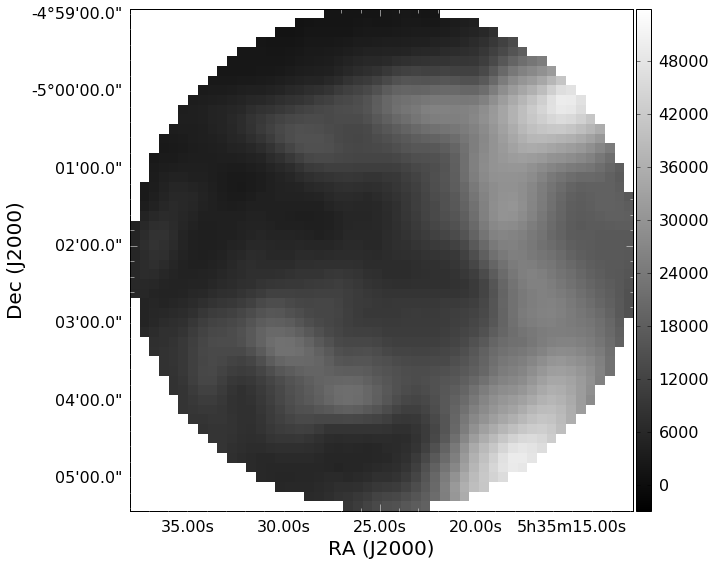

In [172]:
n_shell = 23
mom0 = shell_slabs[n_shell].moment0()
fig = aplpy.FITSFigure(mom0.hdu)
fig.show_grayscale()
cb = fig.add_colorbar()

## Calculate the radial profile

In [182]:
def radial_profile(array, center=None, mode='average',
                   nbins=10, returnSEM=True, removeNaN=True):
    from scipy.stats import binned_statistic, sem
    
    y, x = np.indices(array.shape)
    
    if center is None:
        center = [(array.shape[1] - 1) / 2., (array.shape[0] - 1) / 2.]
        
    r = np.sqrt((center[0] - x) ** 2. + (center[1] - y) ** 2.)
    
    if removeNaN:
        r, array = r[np.isfinite(array)], array[np.isfinite(array)]
    #Profile is the summed pixel values in each bin of radius.
    #profile, rbins = np.histogram(r, weights=array, bins=nbins)
    #print(r.max())
    if mode == 'average':
        # Divide by the number of pixels in each bin
        #profile = profile / np.histogram(r, bins=nbins)[0]
        profile, rbins, binnumber = binned_statistic(
            r, array, 'mean', bins=nbins)
    
    else:
        raise Exception("mode {} not implemented".format(mode))
    
    rbin_centers = (rbins[1:] + rbins[:-1]) / 2.

    if returnSEM:
        "Return the standard error on the mean of each bin."
        SEM = binned_statistic(
            r, array, lambda y: sem(y), bins=nbins)[0]
        return profile, SEM, rbin_centers
    
    else:
        return profile, rbin_centers
    
profile, error, r = radial_profile(np.array(mom0), nbins=50)

## Plot radial profile with integrated shell map.

INFO: Auto-setting vmin to -2.868e+03 [aplpy.core]
INFO: Auto-setting vmax to  5.399e+04 [aplpy.core]


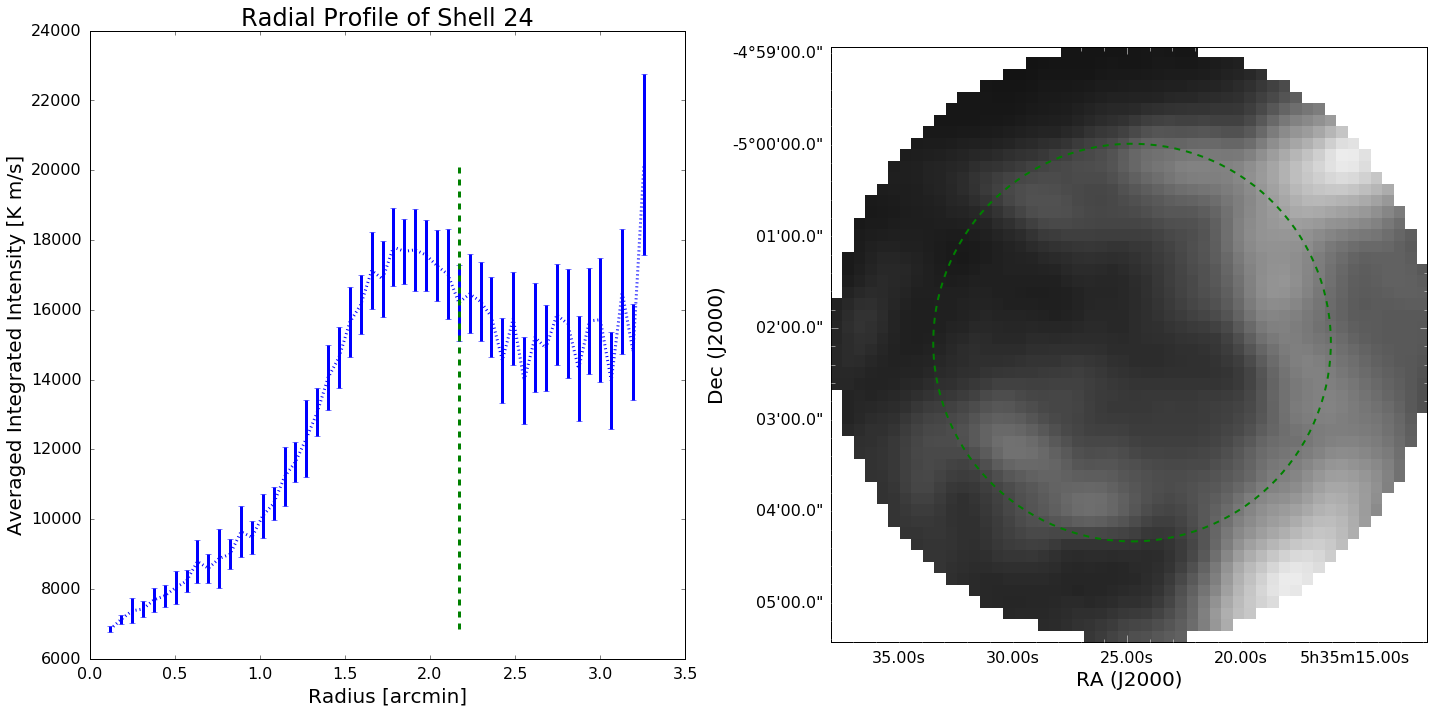

In [183]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.errorbar(r*7.5/60, profile, yerr=error, linestyle="dotted", label="S.E.M.")
ax1.plot(2*[shell_list[n_shell].radius.value * 60], [np.nanmin(profile), np.nanmax(profile)], '--')
ax1.set_xlabel("Radius [arcmin]")
ax1.set_ylabel("Averaged Integrated Intensity [K m/s]")
ax1.set_title("Radial Profile of Shell {}".format(n_shell+1))
shellfig = aplpy.FITSFigure(mom0.hdu, figure=fig, subplot=(1,2,2))
shellfig.show_grayscale()
shellfig.show_circles(shell_list[n_shell].ra.value, shell_list[n_shell].dec.value,
                      radius=shell_list[n_shell].radius.value, edgecolor='green',
                      linestyle='dashed', linewidth=2)
plt.tight_layout()

## Gaussian fit to radial profile, 
Taking the initial guess radius as recorded in AllShells.reg.

In [184]:
from astropy.modeling import fitting, models
radius_pix = shell_list[n_shell].radius.value * 3600 / pix_to_arcsec

gauss_init = models.Gaussian1D(amplitude=np.nanmax(profile) - np.nanmin(profile),
                               mean=radius_pix,
                               stddev=radius_pix / 3.)\
             + models.Const1D(amplitude=np.nanmin(profile))
         
fit = fitting.LevMarLSQFitter()    
#print(r, profile)
gauss_fit = fit(gauss_init, r, profile)

mean, stddev = gauss_fit.mean_0, gauss_fit.stddev_0
sigma_mean = fit.fit_info['param_cov'][1,1]
sigma_stddev = fit.fit_info['param_cov'][2,2]

#print(gauss_init, gauss_fit)
gauss_x = np.linspace(np.nanmin(r), np.nanmax(r), 50)
gauss_y = gauss_fit(gauss_x)

INFO: Auto-setting vmin to -2.868e+03 [aplpy.core]
INFO: Auto-setting vmax to  5.399e+04 [aplpy.core]


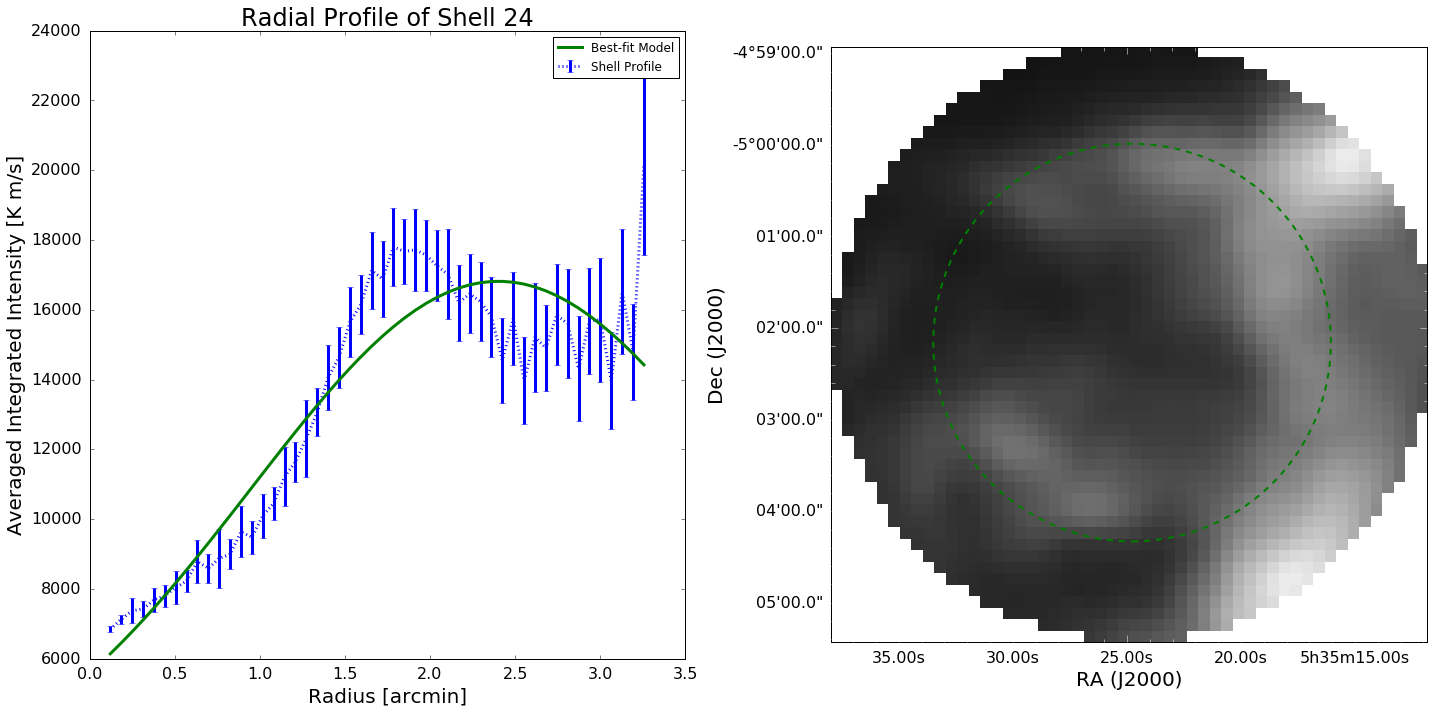

In [185]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.errorbar(r*7.5/ 60, profile,
         yerr=error, linestyle="dotted", label="Shell Profile")
#ax1.plot(2*[shell_list[n_shell].radius.value * 60], [np.nanmin(profile), np.nanmax(profile)], '--')
ax1.plot(gauss_x * pix_to_arcsec / 60, gauss_y, label="Best-fit Model")

ax1.legend()
ax1.set_xlabel("Radius [arcmin]")
ax1.set_ylabel("Averaged Integrated Intensity [K m/s]")
ax1.set_title("Radial Profile of Shell {}".format(n_shell+1))

shellfig = aplpy.FITSFigure(mom0.hdu, figure=fig, subplot=(1,2,2))
shellfig.show_grayscale()
shellfig.show_circles(shell_list[n_shell].ra.value, shell_list[n_shell].dec.value,
                      radius=shell_list[n_shell].radius.value, edgecolor='green',
                      linestyle='dashed', linewidth=2)
plt.tight_layout()

#print(gauss_fit)

In [186]:
thick, sigma_thick = stddev * 7.5 / 60, sigma_stddev * 7.5 / 60
radius, sigma_radius = mean * 7.5 / 60, sigma_mean * 7.5 / 60
print("Shell Thickness = ({} +/- {}) arcminutes".format(round(thick, 2), round(sigma_thick, 2)))
print(r"Shell Radius = ({} +/- {}) arcminutes".format(round(radius, 2), round(sigma_radius, 2)))


Shell Thickness = (1.45 +/- 0.99) arcminutes
Shell Radius = (2.4 +/- 0.05) arcminutes
